In [31]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import geopandas as gpd
import asf_search as asf
import contextily as cx
import numpy as np
import fiona
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from osgeo import gdal

from ARIAtools.contrib.product.utils import get_union_extent, ds_get_extent
from ARIAtools.contrib.product.dataframe import get_df_d12stats
from ARIAtools.contrib.product.plotting import plot_network, plot_pairing, hist_stats, plot_gaps

# new functions
from ARIAtools.contrib.ARIA_product import ARIA_product

In [5]:
%load_ext autoreload
%autoreload 2

# SET UP WORKSPACE

In [6]:
# Data & work Directories
track = 137
work_dir = Path(f'/u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A{track}')

# Initialize
aria_product = ARIA_product(str(work_dir), gunw_dir='ARIA')

In [7]:
aoi_wkt = 'POLYGON((-122.6673 31.4024,-116.7849 31.4024,-116.7849 42.2999,-122.6673 42.2999,-122.6673 31.4024))'

# DOWNLOAD GUNWs FROM ASF VERTEX

In [8]:
os.chdir(aria_product.product_dir)

dct_kw = dict(platform=asf.constants.SENTINEL1,
              processingLevel=asf.constants.GUNW_STD,
              relativeOrbit=str(track),
              flightDirection='Ascending',
              intersectsWith=aoi_wkt)
scenes = asf.geo_search(**dct_kw)

scenes = asf.ASFSearchResults(scenes)
print(f'Number of GUNW to download: {len(scenes)}')

Number of GUNW to download: 8520


In [9]:
# Download

#scenes.download(products_dir, processes=30)

NameError: name 'op' is not defined

# LOAD & PREPARE GUNWS

In [10]:
%%time
# Get dataframe
aria_product.load_gunws(n_jobs=100)

GUNW directory: /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/products
Number of GUNW products: 8520
  Pickle gunws_137.pkl exists.
Get duplicates!
 Found 71 duplicates!
CPU times: user 7.2 s, sys: 125 ms, total: 7.32 s
Wall time: 7.4 s


Number of SAR scenes: 262
Number of GUNWs:  1226


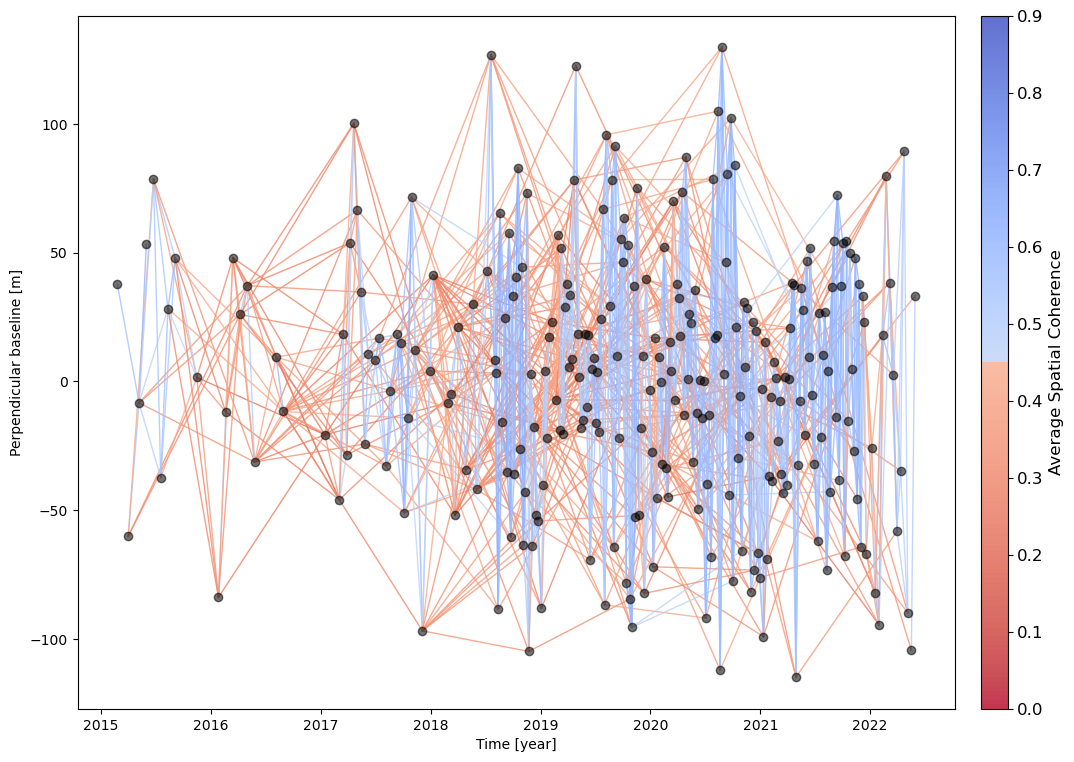

In [11]:
plot_network(aria_product.dataframe, min_coh=0, max_coh=0.9, coh_thresh=0.45)

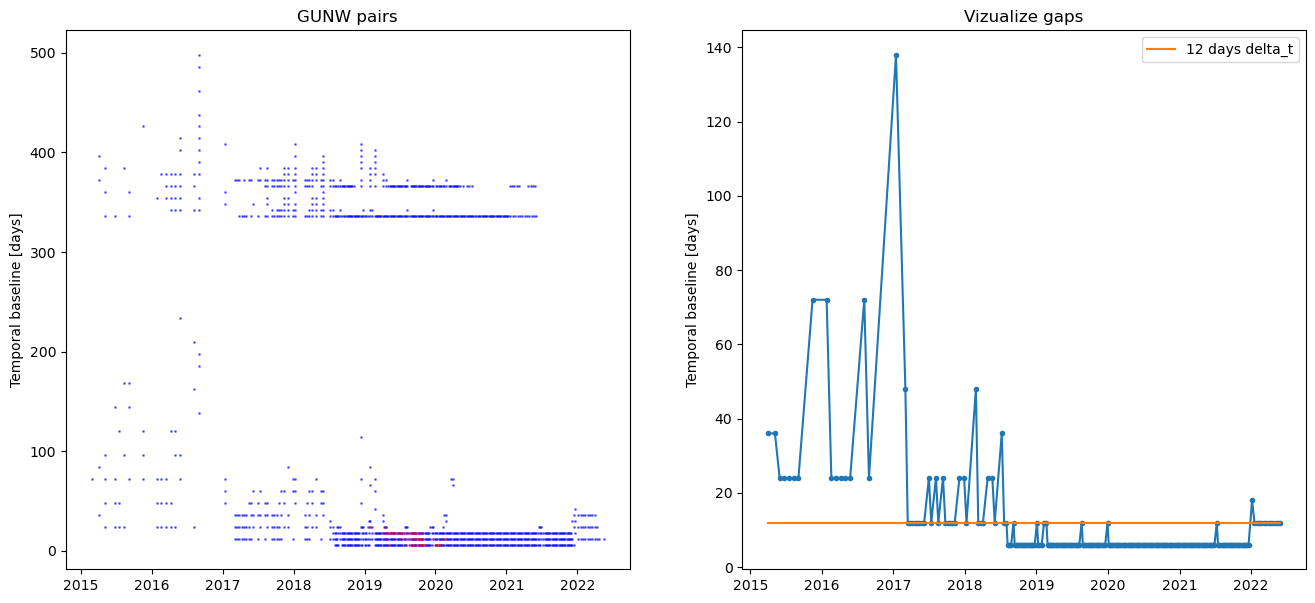

In [12]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
plot_pairing(aria_product.dataframe, color='blue', ax=ax[0])
plot_pairing(aria_product.df_duplicates, color='red',ax=ax[0])
plot_gaps(aria_product.dataframe, min_dt=12, ax=ax[1])

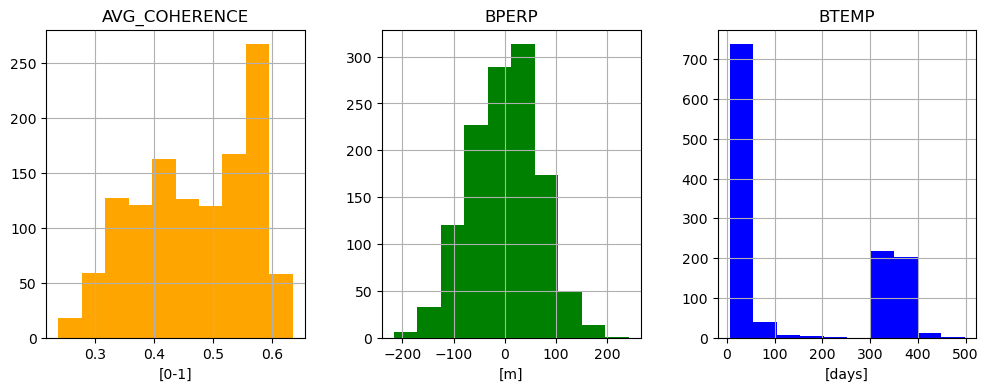

In [13]:
hist_stats(aria_product.dataframe)

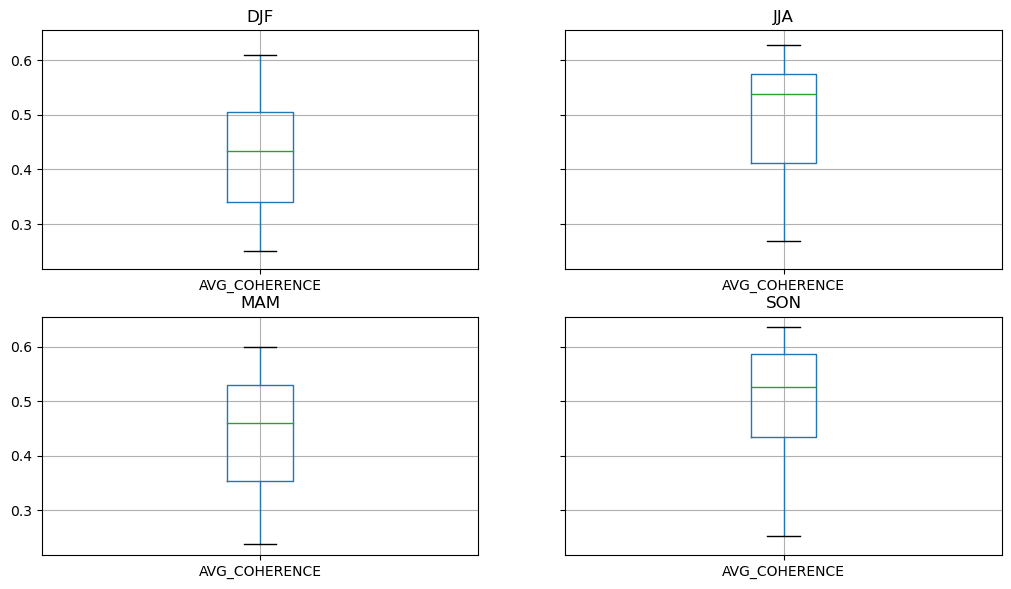

In [14]:
hist_stats(aria_product.dataframe, season_boxplot=True)

<AxesSubplot: >

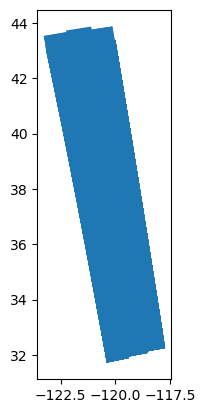

In [15]:
gdf_date12 = aria_product.get_df_date12(aria_product.dataframe)
gdf_date12.plot()

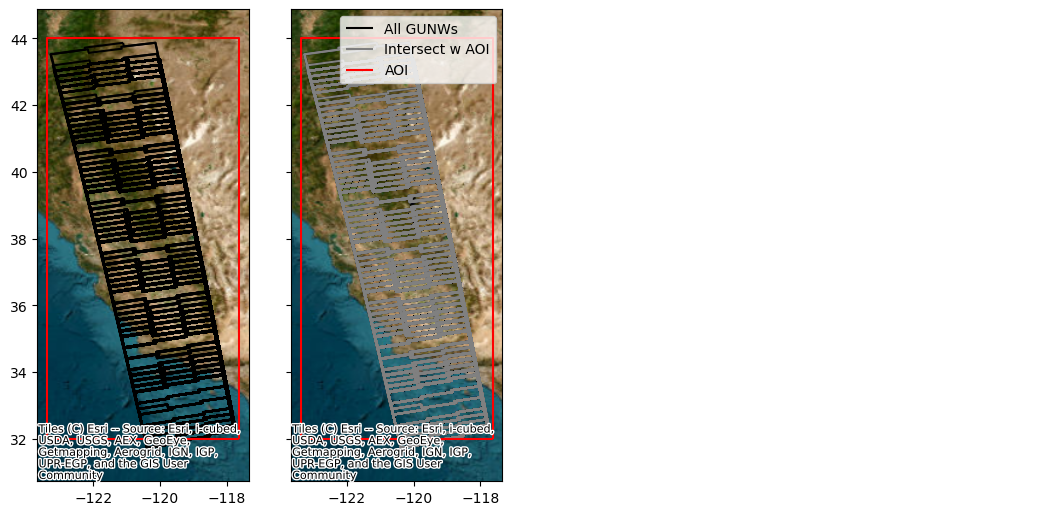

In [16]:
aria_product.find_aoi_intersection(south=32, north=44)
extent = get_union_extent(gdf_date12)
poly_gdf = gpd.GeoDataFrame([1], geometry=[aria_product.aoi],
                            crs=gdf_date12.crs)

#Plot
fig, ax = plt.subplots(1,2, figsize=(6,8), sharey=True)
gdf_date12.exterior.plot(color='black', ax=ax[0])
poly_gdf.exterior.plot(color='red', ax=ax[0])
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs)

#Plot
aria_product.dataframe.exterior.plot(color='black', ax=ax[1], label='All GUNWs')
aria_product.dataframe_filt.exterior.plot(color='gray', ax=ax[1], label='Intersect w AOI')
poly_gdf.exterior.plot(color='red', ax=ax[1], label='AOI')
ax[1].set_ylim([extent[1] -1, extent[3] + 1])  
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs)
ax[1].legend()

In [17]:
# Filter base on the coverage
result = aria_product.filter_min_aoi_coverage(min_coverage_thresh=70)

Disconnected pairs along track
    Number of kept scenes: 1222
    Number of rejected scenes: 4

Pairs not fulfilling coverage requirement
    Number of kept pairs: 1199
    Number of rejected pairs: 23


(30.7286489873561, 44.8723363372984)

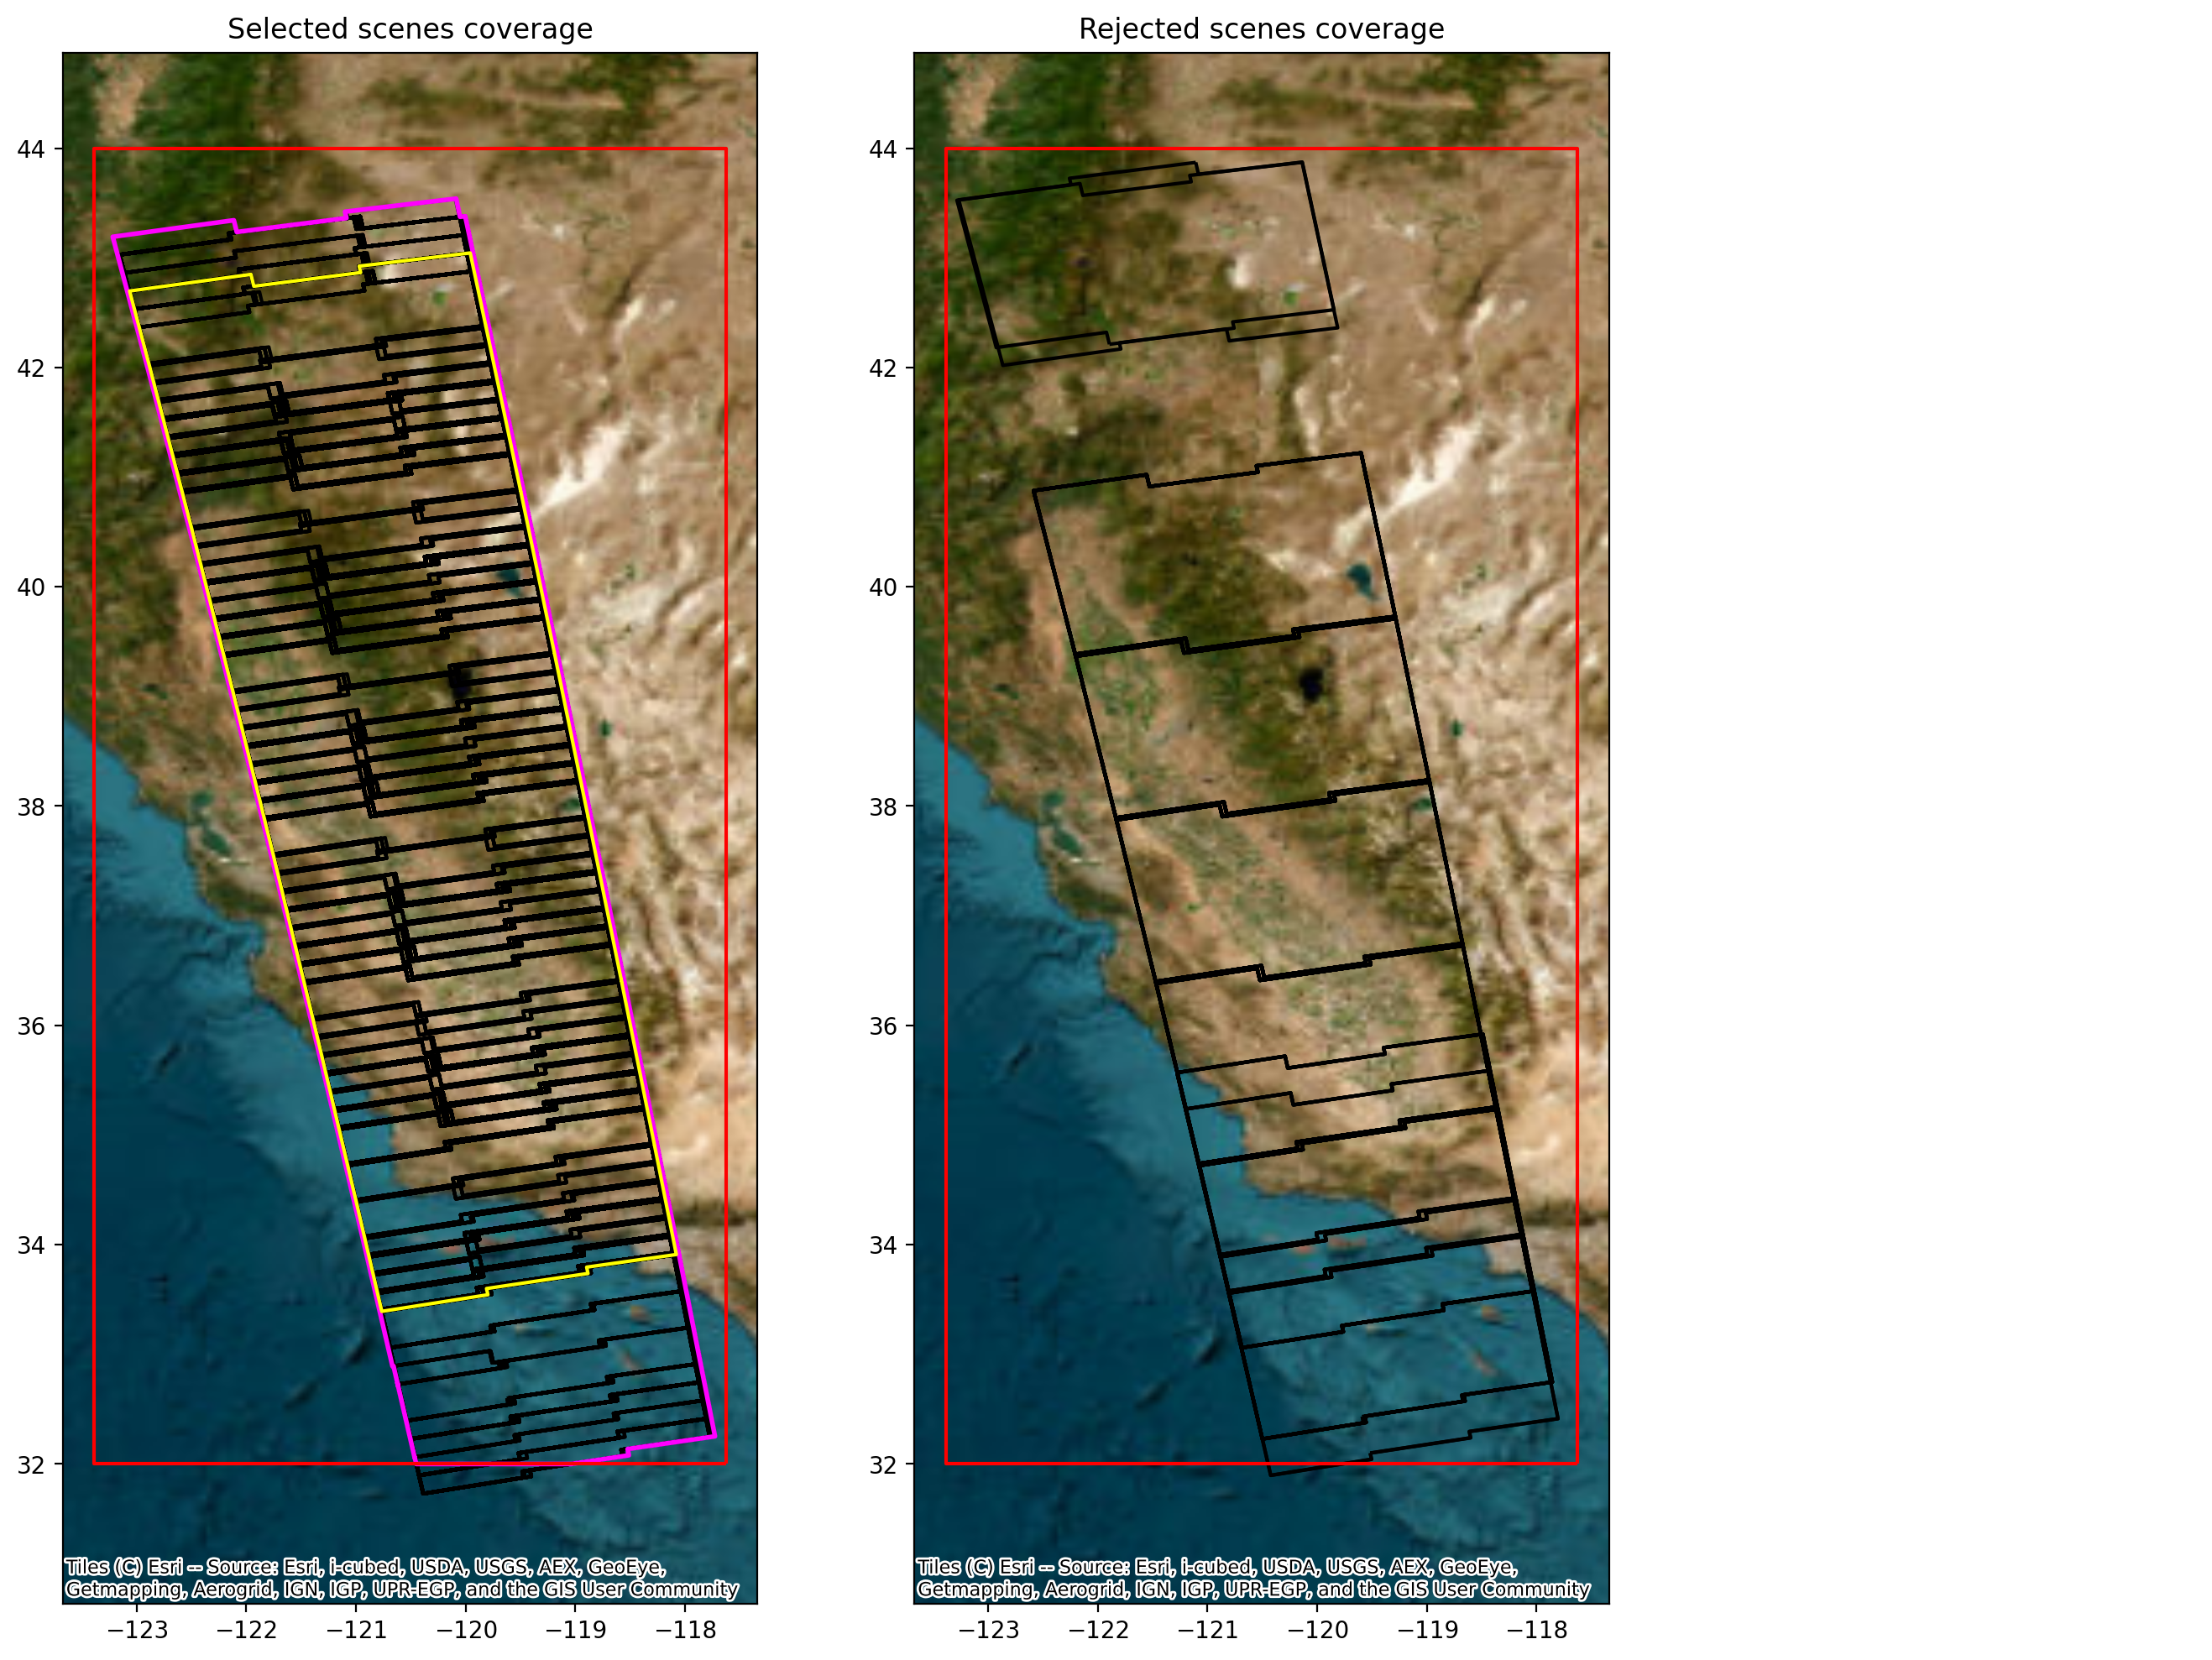

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12, 12), dpi=200)
aria_product.dataframe_fin.exterior.plot(color='black', ax=ax[0])
ax[0].plot(*result[0].unary_union.exterior.xy, c='magenta', lw=2)
result[0][result[0].area == result[0].area.min()].exterior.plot(color='yellow', ax=ax[0], label='Minimum common area')
poly_gdf.exterior.plot(color='red', ax=ax[0])
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs)
ax[0].set_title('Selected scenes coverage')

aria_product.df_rejected_aoi_coverage.exterior.plot(color='black', ax=ax[1])
poly_gdf.exterior.plot(color='red', ax=ax[1])
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs)
ax[1].set_title('Rejected scenes coverage')
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
ax[1].set_ylim([extent[1] -1, extent[3] + 1]) 

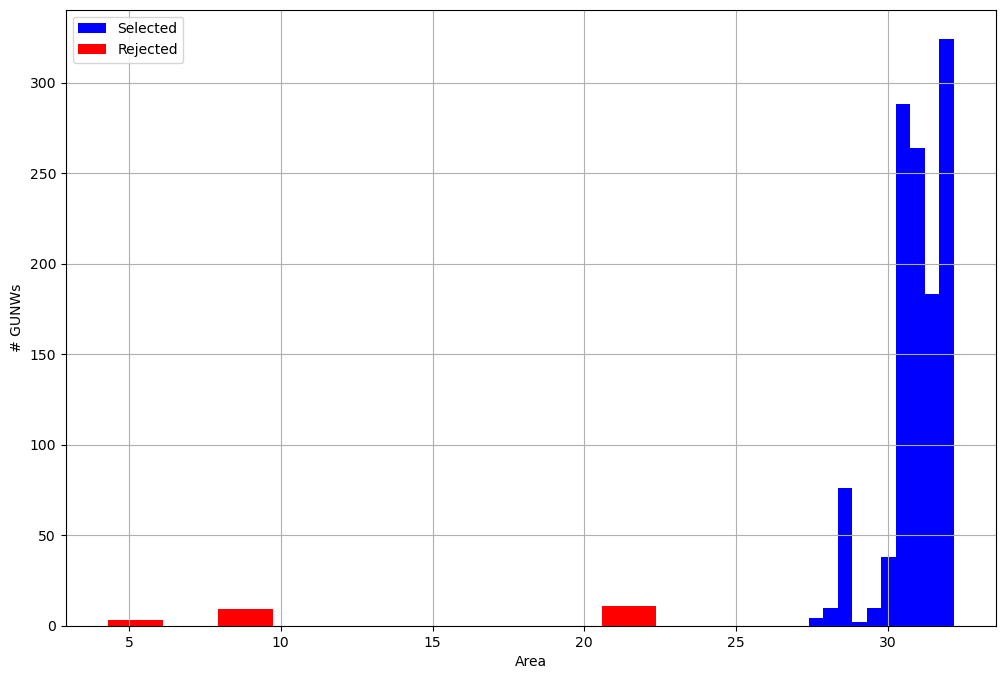

In [19]:
fig, ax = plt.subplots(1, figsize=(12,8))
result[0].area.hist(ax=ax, color='blue', label='Selected')
result[1].area.hist(ax=ax, color='red', label='Rejected')
ax.set_xlabel('Area')
ax.set_ylabel('# GUNWs')
ax.legend()

<AxesSubplot: >

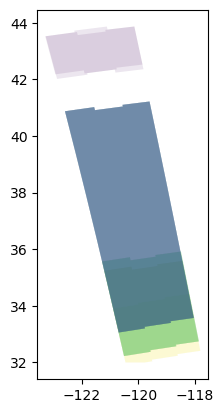

In [20]:
result[1].plot(column='DATE1_DATE2', cmap='viridis', alpha=0.1)

Number of SAR scenes: 260
Number of GUNWs:  1199


Number of rejected GUNWs: 100


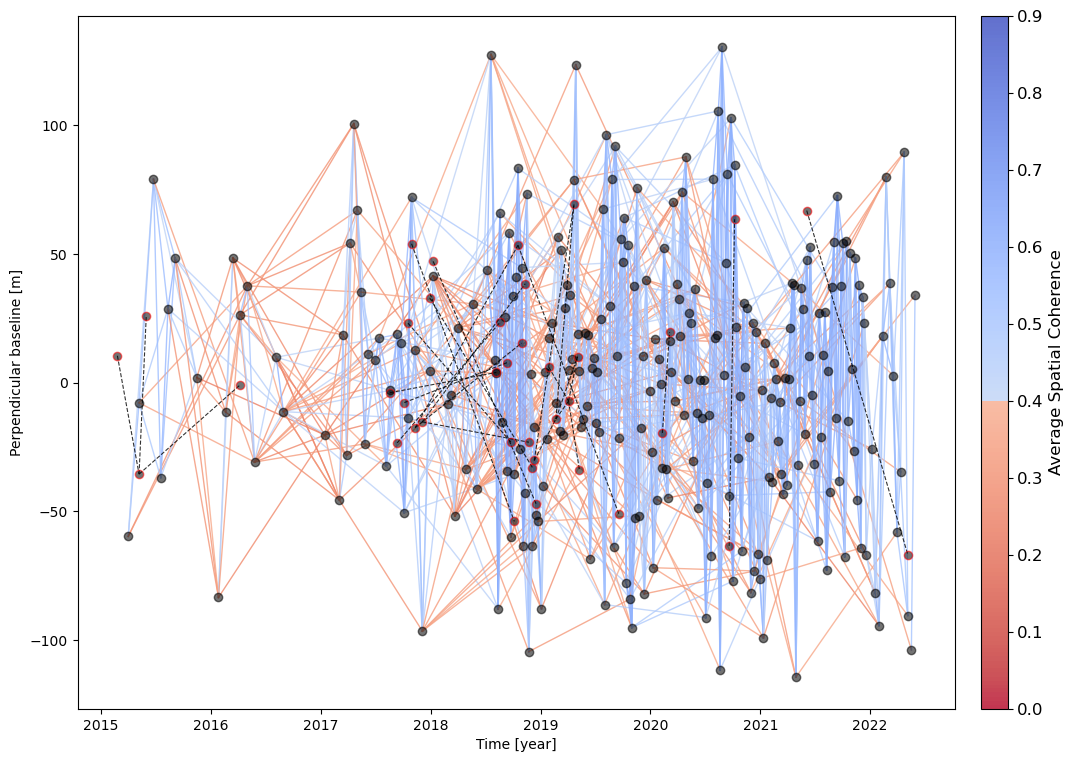

In [21]:
# PLOT final network
rejected = pd.concat([aria_product.df_rejected_aoi_coverage, aria_product.df_rejected_disconnected])
plot_network(aria_product.dataframe_fin,  min_coh=0, max_coh=0.9, coh_thresh=0.4, rejected_df=rejected)
print(f'Number of rejected GUNWs: {rejected.shape[0]}')

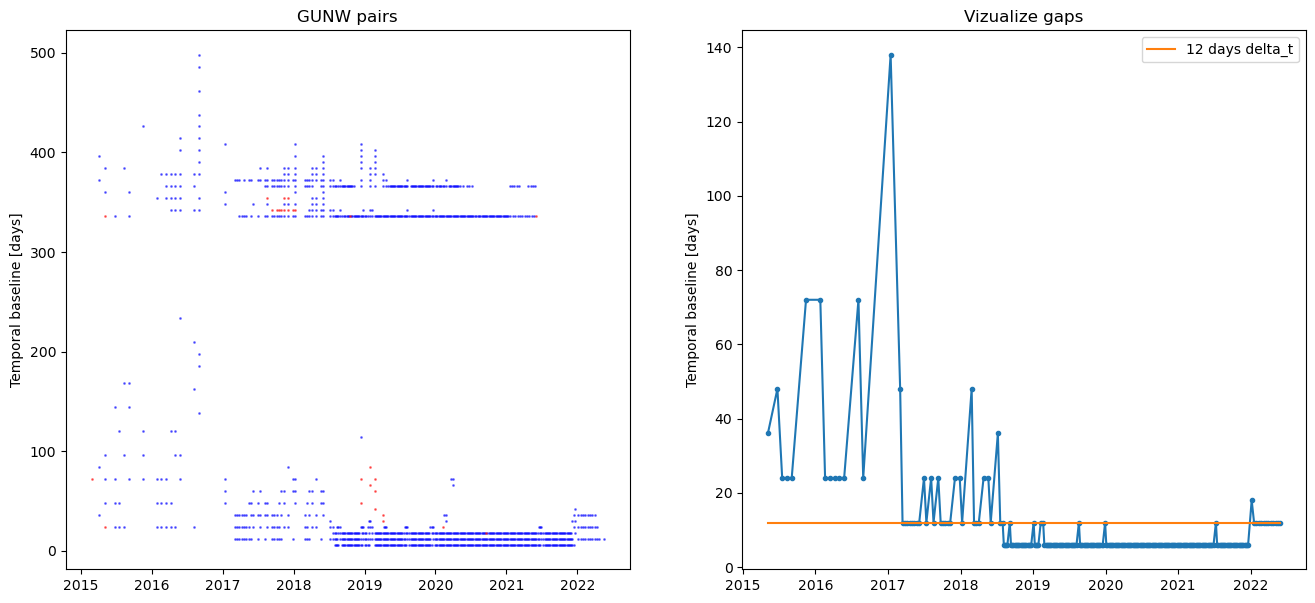

In [28]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
plot_pairing(aria_product.dataframe_fin, color='blue', ax=ax[0])
plot_pairing(rejected, color='red',ax=ax[0])
plot_gaps(aria_product.dataframe_fin, min_dt=12, ax=ax[1])

In [33]:
# Get scenes and number of frames after filtering
aria_product.dataframe_fin.groupby(['DATE2','DATE1'])['TRACK'].count().reset_index()

DATE2      DATE1  TRACK
0    2015-04-01 2015-05-07      7
1    2015-04-01 2015-06-24      7
2    2015-04-01 2016-04-07      7
3    2015-04-01 2016-05-01      7
4    2015-05-07 2015-06-24      7
...         ...        ...    ...
1194 2022-03-31 2022-05-06      7
1195 2022-04-12 2022-04-24      7
1196 2022-04-12 2022-05-06      7
1197 2022-04-24 2022-05-06      7
1198 2022-05-18 2022-05-30      7

[1199 rows x 3 columns]

In [34]:
scenes2export = get_df_d12stats(aria_product.dataframe_fin)
scenes2export

DATE2      DATE1  AVG_COHERENCE       BPERP  BTEMP SEASON
0    2015-04-01 2015-05-07       0.522567   51.538582   36.0    MAM
1    2015-04-01 2015-06-24       0.429867  138.539047   84.0    MAM
2    2015-04-01 2016-04-07       0.331797   86.658607  372.0    MAM
3    2015-04-01 2016-05-01       0.319610   97.029800  396.0    MAM
4    2015-05-07 2015-06-24       0.495215   86.727272   48.0    MAM
...         ...        ...            ...         ...    ...    ...
1194 2022-03-31 2022-05-06       0.492882  -35.500149   36.0    MAM
1195 2022-04-12 2022-04-24       0.475047  124.225731   12.0    MAM
1196 2022-04-12 2022-05-06       0.475370  -55.290794   24.0    MAM
1197 2022-04-24 2022-05-06       0.479569 -177.721146   12.0    MAM
1198 2022-05-18 2022-05-30       0.500670  137.662277   12.0    MAM

[1199 rows x 6 columns]

## REFINE SELECTION BASED ON SOME CRITERIA

In [ ]:
# PLACEHOLDER FOR MIDNIGHT CROSSING
'''
delta_t = np.diff(np.sort(gunw_df.DATE1.unique())).astype('timedelta64[D]')
np.sort(gunw_df.DATE1.unique())[np.r_[False, delta_t < timedelta(days=2)]]

delta_t = np.diff(np.sort(gunw_df.DATE2.unique())).astype('timedelta64[D]')
np.sort(gunw_df.DATE2.unique())[np.r_[False, delta_t < timedelta(days=2)]]
'''

In [41]:
# filter based on season
# JOIN DATE1 and DATE2 in DATE1_DATE2 to compare with dataframe_fin
scenes2export = get_df_d12stats(aria_product.dataframe_fin)
scenes2export = scenes2export[scenes2export.SEASON == 'MAM']
scenes2export

DATE2      DATE1  AVG_COHERENCE       BPERP  BTEMP SEASON
0    2015-04-01 2015-05-07       0.522567   51.538582   36.0    MAM
1    2015-04-01 2015-06-24       0.429867  138.539047   84.0    MAM
2    2015-04-01 2016-04-07       0.331797   86.658607  372.0    MAM
3    2015-04-01 2016-05-01       0.319610   97.029800  396.0    MAM
4    2015-05-07 2015-06-24       0.495215   86.727272   48.0    MAM
...         ...        ...            ...         ...    ...    ...
1194 2022-03-31 2022-05-06       0.492882  -35.500149   36.0    MAM
1195 2022-04-12 2022-04-24       0.475047  124.225731   12.0    MAM
1196 2022-04-12 2022-05-06       0.475370  -55.290794   24.0    MAM
1197 2022-04-24 2022-05-06       0.479569 -177.721146   12.0    MAM
1198 2022-05-18 2022-05-30       0.500670  137.662277   12.0    MAM

[331 rows x 6 columns]

In [48]:
# This could be valuable to check number of conncetion per date to kick out dates with only 1 connection
scenes2export.groupby(['DATE1', "DATE2"], group_keys=True).apply(lambda x: x)#.index.levels[0]

DATE2      DATE1  AVG_COHERENCE       BPERP  \
DATE1      DATE2                                                              
2015-05-07 2015-04-01 0    2015-04-01 2015-05-07       0.522567   51.538582   
2015-06-24 2015-04-01 1    2015-04-01 2015-06-24       0.429867  138.539047   
           2015-05-07 4    2015-05-07 2015-06-24       0.495215   86.727272   
2015-07-18 2015-05-07 5    2015-05-07 2015-07-18       0.474446  -28.999241   
2015-08-11 2015-05-07 6    2015-05-07 2015-08-11       0.456393   36.476585   
...                               ...        ...            ...         ...   
2022-05-06 2022-04-12 1196 2022-04-12 2022-05-06       0.475370  -55.290794   
           2022-04-24 1197 2022-04-24 2022-05-06       0.479569 -177.721146   
2022-05-18 2021-05-17 1063 2021-05-17 2022-05-18       0.354410 -140.613571   
2022-05-30 2021-05-29 1071 2021-05-29 2022-05-30       0.390916   53.936150   
           2022-05-18 1198 2022-05-18 2022-05-30       0.500670  137.662277   

                            BTEMP SEASON  
DATE1      DATE2                          
2015-05-07 2015-04-01 0      36.0    MAM  
2015-06-24 2015-04-01 1      84.0    MAM  
           2015-05-07 4      48.0    MAM  
2015-07-18 2015-05-07 5      72.0    MAM  
2015-08-11 2015-05-07 6      96.0    MAM  
...                           ...    ...  
2022-05-06 2022-04-12 1196   24.0    MAM  
           2022-04-24 1197   12.0    MAM  
2022-05-18 2021-05-17 1063  366.0    MAM  
2022-05-30 2021-05-29 1071  366.0    MAM  
           2022-05-18 1198   12.0    MAM  

[331 rows x 6 columns]

In [39]:
# filter based on temporal baseline
scenes2export = aria_product.dataframe_fin[aria_product.dataframe_fin['BTEMP'] < 16]
get_df_d12stats(scenes2export)

DATE2      DATE1  AVG_COHERENCE       BPERP  BTEMP SEASON
0   2017-03-03 2017-03-15       0.519175   63.657616   12.0    MAM
1   2017-03-15 2017-03-27       0.495050  -46.848713   12.0    MAM
2   2017-03-27 2017-04-08       0.460051   82.045387   12.0    MAM
3   2017-04-08 2017-04-20       0.466488   46.554863   12.0    MAM
4   2017-04-20 2017-05-02       0.505988  -33.845036   12.0    MAM
..         ...        ...            ...         ...    ...    ...
412 2022-03-19 2022-03-31       0.560476  -62.355991   12.0    MAM
413 2022-03-31 2022-04-12       0.494394   24.508097   12.0    MAM
414 2022-04-12 2022-04-24       0.475047  124.225731   12.0    MAM
415 2022-04-24 2022-05-06       0.479569 -177.721146   12.0    MAM
416 2022-05-18 2022-05-30       0.500670  137.662277   12.0    MAM

[417 rows x 6 columns]

In [22]:
# Save aoi box for exporting
aria_product.save_aria_bbox()

# EXPORT PRODUCTS WITH DASK

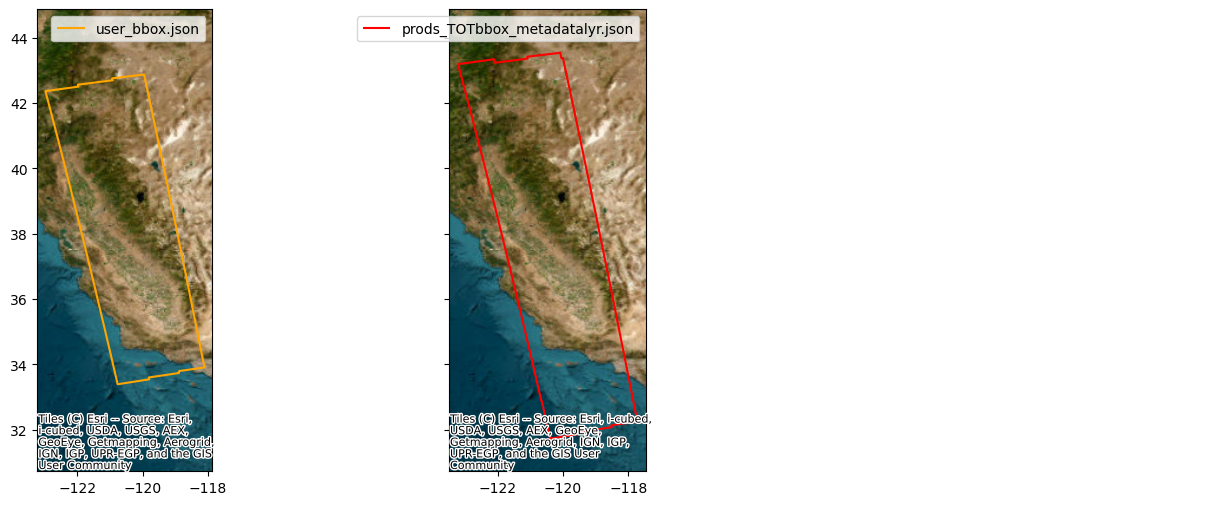

In [23]:
#Lets double check the aoi 
geo_bbox = gpd.read_file(aria_product.user_json)
geo_bbox1 = gpd.read_file(aria_product.product_json)

fig, ax = plt.subplots(1,2, figsize=(10, 6), sharey=True)
geo_bbox.exterior.plot(ax=ax[0], color='orange', label='user_bbox.json')
geo_bbox1.exterior.plot(ax=ax[1], color='red', label='prods_TOTbbox_metadatalyr.json')
#unioned_gdf[unioned_gdf.area == unioned_gdf.area.min()].exterior.plot(color='yellow', ax=ax[0])
#unioned_gdf[unioned_gdf.area == unioned_gdf.area.min()].exterior.plot(color='yellow', ax=ax[1])
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery, crs='EPSG:4326', zorder=0)
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery, crs='EPSG:4326', zorder=0)
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
ax[1].set_ylim([extent[1] -1, extent[3] + 1]) 
for a in ax: a.legend()

In [24]:
# Make the product dictonary of selected GUNWs for export
aria_product.generate_product_dict()

In [25]:
# Prepare dem and water mask
aria_product.prepare_dem()
aria_product.prepare_watermask()

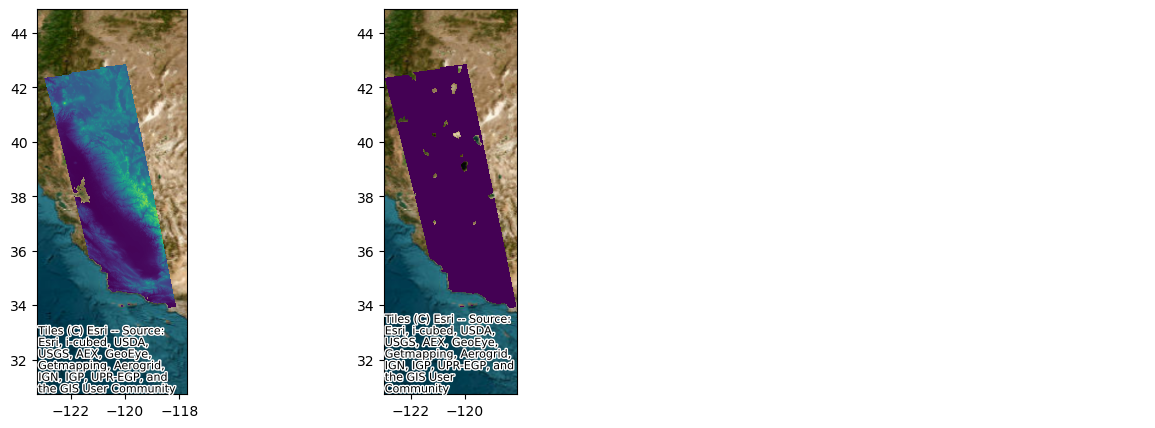

In [27]:
mask = gdal.Open(aria_product.mask)
mask_extent = ds_get_extent(mask)

# PLOT TO VERIFY DEM AND WATER MASK
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(np.ma.masked_equal(aria_product.dem.ReadAsArray(),0),
             extent=aria_product.dem_extent, zorder=1)
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery,
               crs='EPSG:4326', zorder=0)

mask_extent = ds_get_extent(mask)
ax[1].imshow(np.ma.masked_equal(mask.ReadAsArray(),0),
             extent=mask_extent, zorder=1)
ax[1].set_ylim([extent[1] -1, extent[3] + 1]) 
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery,
               crs='EPSG:4326', zorder=0)

In [ ]:
%%time
# export unwrapped phase
# mask_conn0 - to mask phase under the connected component 0 [unreliable unwrapped phase by snaphu]
aria_product.export_layers(layer='unwrappedPhase', n_jobs=30, mask_conn0=True)

Running GUNW unwrappedPhase and connectedComponents in parallel!


2023-12-12 14:53:56,307 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-75956/worker-phaj7th8', purging
2023-12-12 14:53:56,307 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-75956/worker-6e865o09', purging
2023-12-12 14:53:56,307 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-75956/worker-x0x2wqeb', purging
2023-12-12 14:53:56,308 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-75956/worker-49q8ih34', purging
2023-12-12 14:53:56,308 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-75956/worker-lnwgywj2', purging
2023-12-12 14:53:56,308 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-75956/worker-gllwlak_', purging
2023-12-12 14:53:56,308 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-wo

Link: http://127.0.0.1:8787/status
Run 0 jobs with 30 workers.


In [ ]:
%%time
# export unwrapped phase
aria_product.export_layers(layer='coherence', n_jobs=30)

Running GUNW coherence in parallel!
Link: http://127.0.0.1:35913/status
Run 567 jobs with 30 workers.


Task was destroyed but it is pending!
task: <Task pending name='Task-719952' coro=<RequestHandler._execute() running at /home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/tornado/web.py:1713> wait_for=<Task finished name='Task-2334924' coro=<WSHandler.on_message() done, defined at /home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/bokeh/server/views/ws.py:225> result=None> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/tornado/web.py:2361]>


CPU times: user 2min 17s, sys: 1min 42s, total: 4min
Wall time: 6min 36s


In [ ]:
aria_product.mask

'/u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/mask/watermask.msk'

In [ ]:
%%time
# export unwrapped phase
aria_product.export_layers(layer='incidenceAngle', n_jobs=1)
aria_product.export_layers(layer='azimuthAngle', n_jobs=1)
aria_product.export_layers(layer='bPerpendicular', n_jobs=1)

[autoreload of ARIAtools.contrib.ARIA_product failed: Traceback (most recent call last):
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/home/govorcin/tools/miniconda3/envs/aria/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    refs = gc.get_referrers(old)
           ^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

Run 1 jobs with 1 workers.
Run 1 jobs with 1 workers.
CPU times: user 13.3 s, sys: 12.4 s, total: 25.7 s
Wall time: 1min 24s


In [ ]:
# Read perpdincular baseline text file
pd.read_csv(aria_product.aria_dir / 'stack_stats.csv')

Unnamed: 0        DATE1_DATE2  AVG_COHERENCE       BPERP  BTEMP
0              0  20150507_20150401       0.522567  -51.538580   36.0
1              1  20150624_20150401       0.429867 -138.539050   84.0
2              2  20150624_20150507       0.495215  -86.727270   48.0
3              3  20150718_20150507       0.474446   28.999240   72.0
4              4  20150718_20150624       0.534020  115.626945   24.0
...          ...                ...            ...         ...    ...
1194        1194  20220506_20220412       0.475370   55.290794   24.0
1195        1195  20220506_20220424       0.479569  177.721150   12.0
1196        1196  20220518_20210517       0.354410  140.613570  366.0
1197        1197  20220530_20210529       0.390916  -53.936150  366.0
1198        1198  20220530_20220518       0.500670 -137.662280   12.0

[1199 rows x 5 columns]

# GENERATE STACK AND PREPARE MINTPY INPUTS

In [ ]:
aria_product.prepare_stack()

Creating directory:  /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/stack
Number of unwrappedPhase files discovered:  1199
[==================================================] 20220530_20220518    0s /     0s 
unwrapStack : stack generated

Number of coherence files discovered:  1199
[==================================================] 20220530_20220518    0s /     0s 
cohStack : stack generated

Number of connectedComponents files discovered:  1199
[==================================================] 20220530_20220518    0s /     0s 
connCompStack : stack generated


In [ ]:
aria_product.prep_mintpy()

multilook x/ystep: 1/1
multilook method : nearest
search input data file info:
unwFile       : /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/stack/unwrapStack.vrt
corFile       : /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/stack/cohStack.vrt
connCompFile  : /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/stack/connCompStack.vrt
demFile       : /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/DEM/glo_90.dem
incAngleFile  : /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/incidenceAngle/20150507_20150401.vrt
azAngleFile   : /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/azimuthAngle/20150507_20150401.vrt
waterMaskFile : /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/mask/watermask.msk
update mode: False
extract metadata from /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A137/ARIA/stack/unwrapStack.vrt
--------------------------------------------------
create HDF5 file: ./inputs/ifgramStack.h5 with w mode
create dataset  : date

: 